# Undercomplete Autoencoders

## Step 1: Import libraries

In [1]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
from keras.models import Model, load_model # for creating a Neural Network Autoencoder model
from keras import Input # for instantiating a keras tensor
from keras.layers import Dense, LeakyReLU, BatchNormalization # for adding layers to AE model
from tensorflow.keras.utils import plot_model # for plotting model diagram


# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version


# Sklearn
import sklearn # for model evaluation
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.preprocessing import MinMaxScaler # for rescaling metrics to fit into 0 to 1 range
from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.linear_model import LogisticRegression # for building logistic regression models
from sklearn.metrics import classification_report # for model evaluation metrics


# Visualization
import matplotlib
import matplotlib.pyplot as plt # for plotting model loss
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version


# Other utilities
import sys
import os

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])
#print(main_dir)

pandas: 2.0.3
sklearn: 1.2.2
matplotlib: 3.7.1
graphviz: 0.20.3


## Step 2: Prepare the data

In [2]:
# Set Pandas options to display more columns
pd.options.display.max_columns=50

# Read in the weather data csv
df=pd.read_csv(main_dir+'/content/weatherAUS.csv', encoding='utf-8')

# Drop records where target RainTomorrow=NaN
#df=df[pd.isnull(df['RainTomorrow'])==False]

# Drop rows where any of the values are missing.
# Note, in this case it drops ~60% of the rows. Since we are using this data just as an example, it's ok.
# However, when you work with your own data, you may want to explore other options to fill in NA's with, say, mean values
df=df.dropna(axis=0)

# Create a flag for RainToday and RainTomorrow, note RainTomorrowFlag will be our target variable
df['RainTodayFlag']=df['RainToday'].apply(lambda x: 1 if x=='Yes' else 0)
df['RainTomorrowFlag']=df['RainTomorrow'].apply(lambda x: 1 if x=='Yes' else 0)

# Show a snaphsot of data
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainTodayFlag,RainTomorrowFlag
6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,0,0
6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,0,0
6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,0,0
6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,0,0
6054,2009-01-06,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,WNW,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142298,2017-06-20,Darwin,19.3,33.4,0.0,6.0,11.0,ENE,35.0,SE,NE,9.0,20.0,63.0,32.0,1013.9,1010.5,0.0,1.0,24.5,32.3,No,No,0,0
142299,2017-06-21,Darwin,21.2,32.6,0.0,7.6,8.6,E,37.0,SE,SE,13.0,11.0,56.0,28.0,1014.6,1011.2,7.0,0.0,24.8,32.0,No,No,0,0
142300,2017-06-22,Darwin,20.7,32.8,0.0,5.6,11.0,E,33.0,E,W,17.0,11.0,46.0,23.0,1015.3,1011.8,0.0,0.0,24.8,32.1,No,No,0,0
142301,2017-06-23,Darwin,19.5,31.8,0.0,6.2,10.6,ESE,26.0,SE,NNW,9.0,17.0,62.0,58.0,1014.9,1010.7,1.0,1.0,24.8,29.2,No,No,0,0


In [3]:
# Select data for modeling
# Extracts the features ('MinTemp', 'MaxTemp', ..., 'RainTodayFlag') from the DataFrame for modeling.
X = df[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed',
        'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
        'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainTodayFlag']]

# Extracts the target variable ('RainTomorrowFlag') from the DataFrame.
y = df['RainTomorrowFlag'].values

# Scale training data so it is between 0 and 1
# Initializes a MinMaxScaler object to scale the features to a range between 0 and 1.
scaler = MinMaxScaler()

# Scales the features in X using the MinMaxScaler object created above.
X_scaled = scaler.fit_transform(X)

# Create training and testing samples
# Splits the scaled features and the target variable into training and testing sets.
# The testing set size is set to 20% of the total data, and the random_state ensures reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)
# X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=0)

## Step 3: Let's build the undercomplete autoencoder model using functional Keras APi

Model: "Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (InputLayer)    [(None, 17)]              0         
                                                                 
 Encoder-Layer (Dense)       (None, 17)                306       
                                                                 
 Encoder-Layer-Normalizatio  (None, 17)                68        
 n (BatchNormalization)                                          
                                                                 
 Encoder-Layer-Activation (  (None, 17)                0         
 LeakyReLU)                                                      
                                                                 
 Bottleneck-Layer (Dense)    (None, 8)                 144       
                                                                 
 Decoder-Layer (Dense)       (None, 17)          

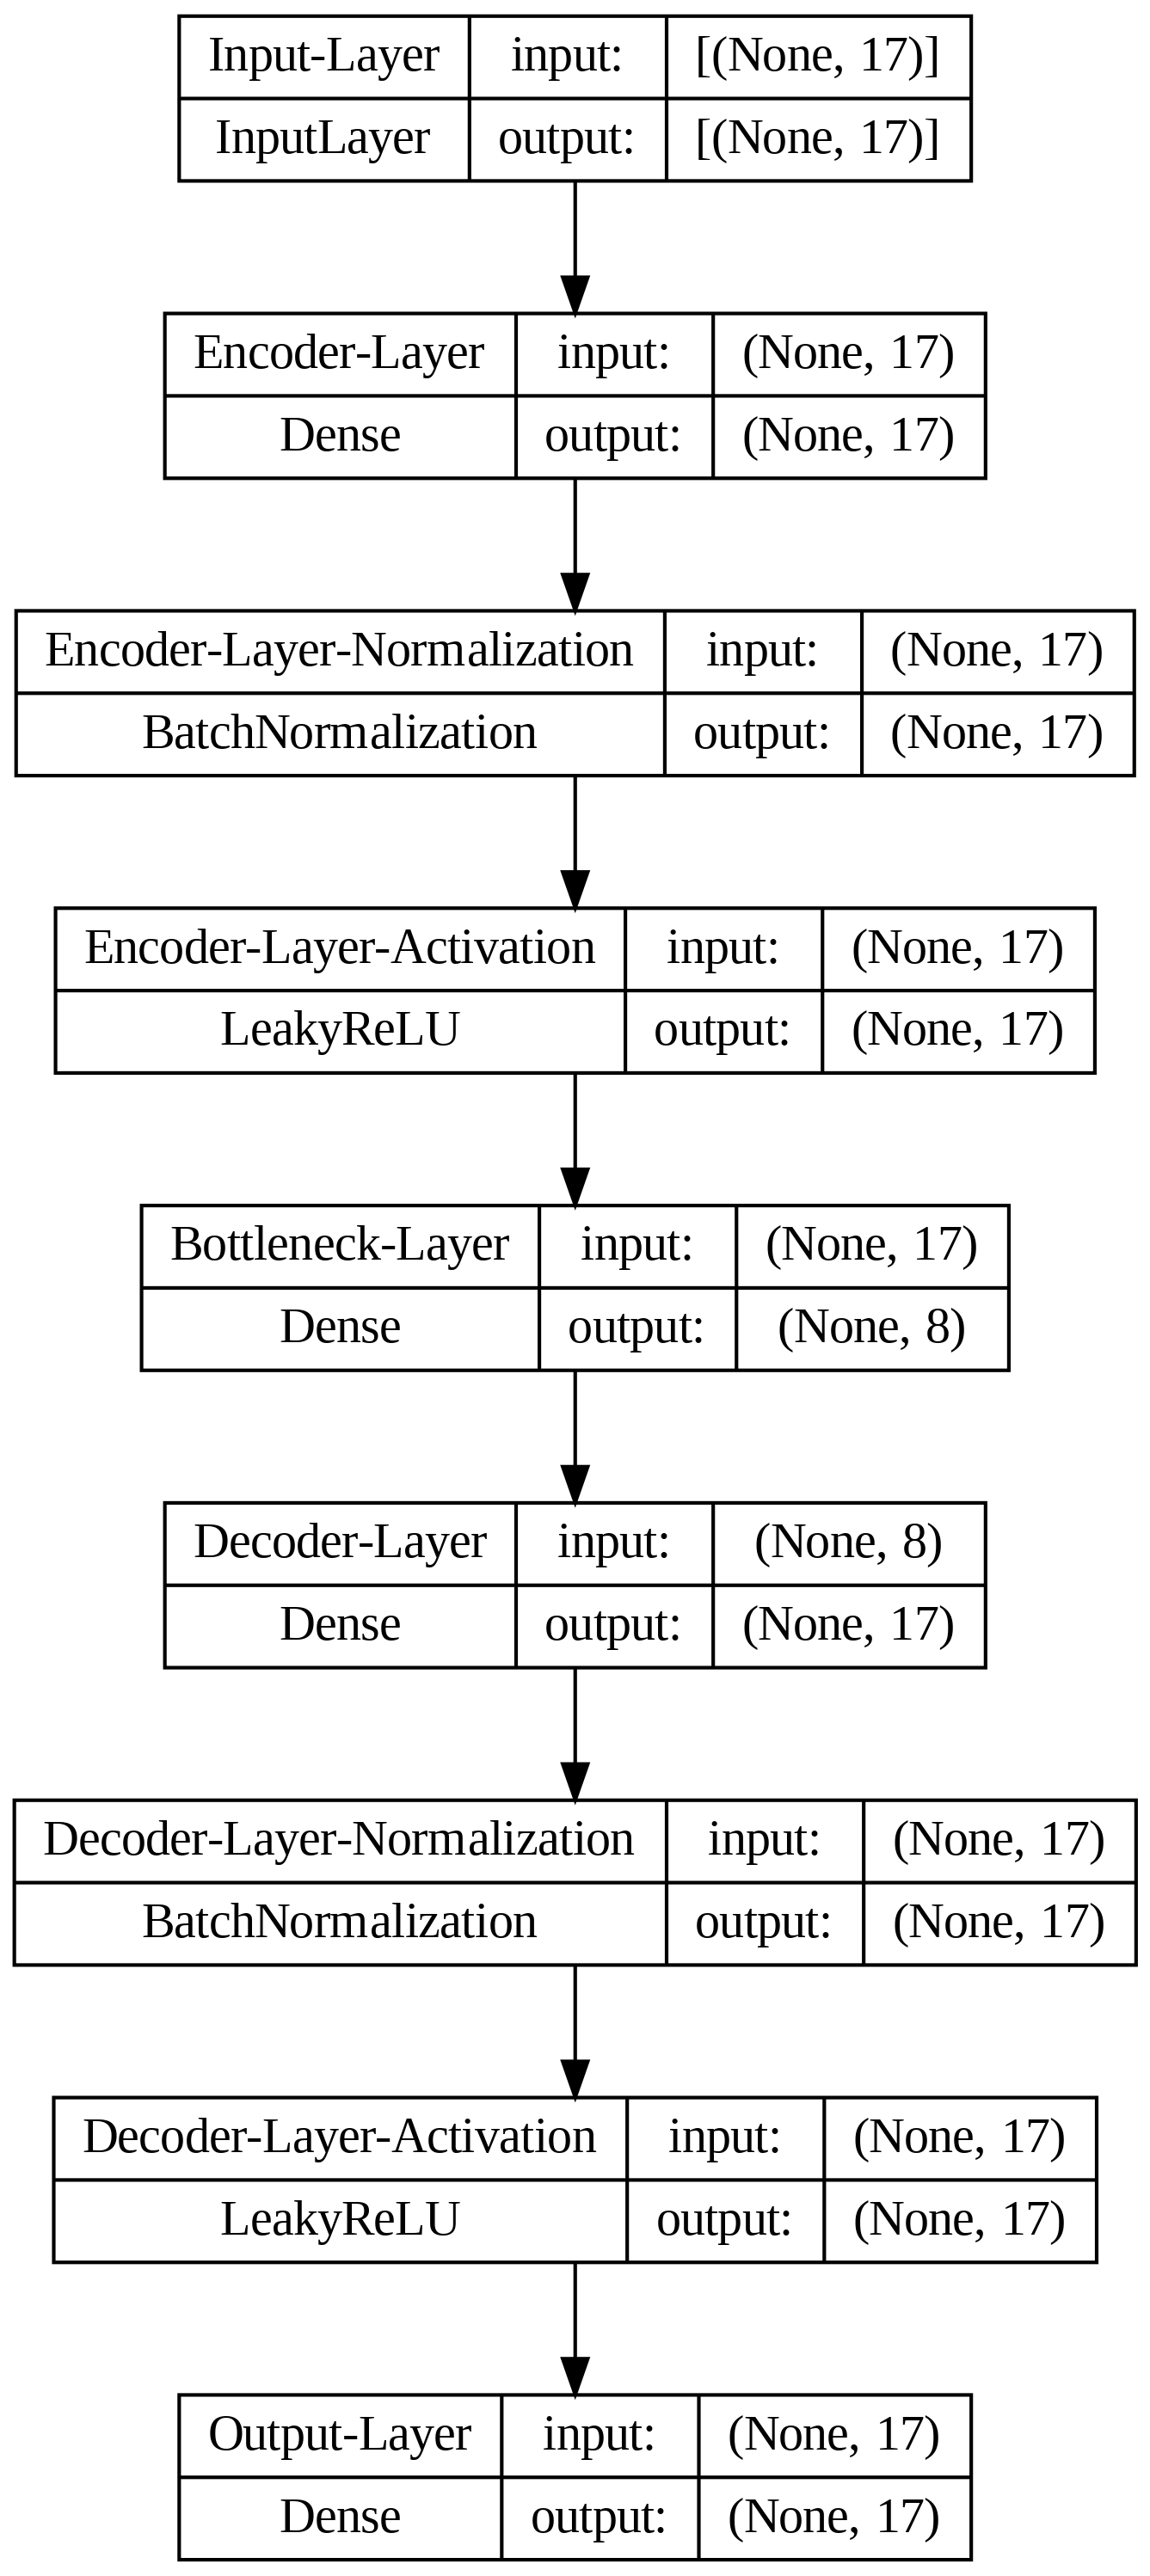

In [4]:
#--- Define Shapes
# Calculates the number of input neurons based on the number of features in X_train.
n_inputs = X_train.shape[1] # number of input neurons = the number of features X_train
# Sets the number of neurons in the bottleneck layer to half the number of input neurons.
n_bottleneck = round(float(n_inputs) / 2.0) # bottleneck to have half the number of neurons

#--- Input Layer
# Defines the input layer with a shape matching the number of input neurons.
visible = Input(shape=(n_inputs,), name='Input-Layer') # Specify input shape

#--- Encoder Layer
# Adds a dense (fully connected) layer with the same number of neurons as the input.
e = Dense(units=n_inputs, name='Encoder-Layer')(visible)
# Adds batch normalization to normalize the activations of the previous layer.
e = BatchNormalization(name='Encoder-Layer-Normalization')(e)
# Applies Leaky ReLU activation function to the output of the previous layer.
e = LeakyReLU(name='Encoder-Layer-Activation')(e)

#--- Bottleneck
# Adds a bottleneck layer with the number of neurons specified earlier.
bottleneck = Dense(units=n_bottleneck, name='Bottleneck-Layer')(e) # it is basically the middle layer where the both input and output layer nodes are compared

#--- Decoder Layer
# Adds a dense layer with the same number of neurons as the input, reconstructing the original input.
d = Dense(units=n_inputs, name='Decoder-Layer')(bottleneck)
# Adds batch normalization to normalize the activations of the previous layer.
d = BatchNormalization(name='Decoder-Layer-Normalization')(d)
# Applies Leaky ReLU activation function to the output of the previous layer.
d = LeakyReLU(name='Decoder-Layer-Activation')(d)

#--- Output layer
# Adds the output layer with linear activation function.
# This is appropriate for regression tasks where we want the model to directly predict numeric values.
output = Dense(units=n_inputs, activation='linear', name='Output-Layer')(d)

# Define autoencoder model
# Creates the autoencoder model with input and output defined.
model = Model(inputs=visible, outputs=output, name='Autoencoder-Model')

# Compile autoencoder model
# Compiles the autoencoder model with Adam optimizer and Mean Squared Error (MSE) loss function.
model.compile(optimizer='adam', loss='mse')

# Print model summary
# Prints a summary of the autoencoder model architecture.
print(model.summary())

# Plot the autoencoder model diagram
# Generates a visual representation of the autoencoder model architecture and saves it as an image file.
plot_model(model, to_file=main_dir+'/content/Autoencoder.png', show_shapes=True, dpi=300)

### Hope you already got that we used the batch normalization, which applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1. While it is not mandatory, it often helps with model performance.

### Let's train the model over ten epochs

In [5]:
# Fit the autoencoder model to reconstruct input
# Trains the autoencoder model on the training data with specified epochs and batch size.
# Verbose mode prints training progress.
# Validation data is used to evaluate the model's performance after each epoch.
history = model.fit(X_train, X_train, epochs=10, batch_size=16, verbose=1, validation_data=(X_test, X_test))

Epoch 1/10
2821/2821 [==============================] - 19s 6ms/step - loss: 0.0271 - val_loss: 0.0042
Epoch 2/10
2821/2821 [==============================] - 10s 3ms/step - loss: 0.0067 - val_loss: 0.0026
Epoch 3/10
2821/2821 [==============================] - 8s 3ms/step - loss: 0.0055 - val_loss: 0.0020
Epoch 4/10
2821/2821 [==============================] - 7s 2ms/step - loss: 0.0048 - val_loss: 0.0019
Epoch 5/10
2821/2821 [==============================] - 7s 3ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 6/10
2821/2821 [==============================] - 8s 3ms/step - loss: 0.0041 - val_loss: 0.0016
Epoch 7/10
2821/2821 [==============================] - 7s 2ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 8/10
2821/2821 [==============================] - 8s 3ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 9/10
2821/2821 [==============================] - 6s 2ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 10/10
2821/2821 [==============================] - 7s 3ms/step - loss: 0.0

### Plot the loss chart

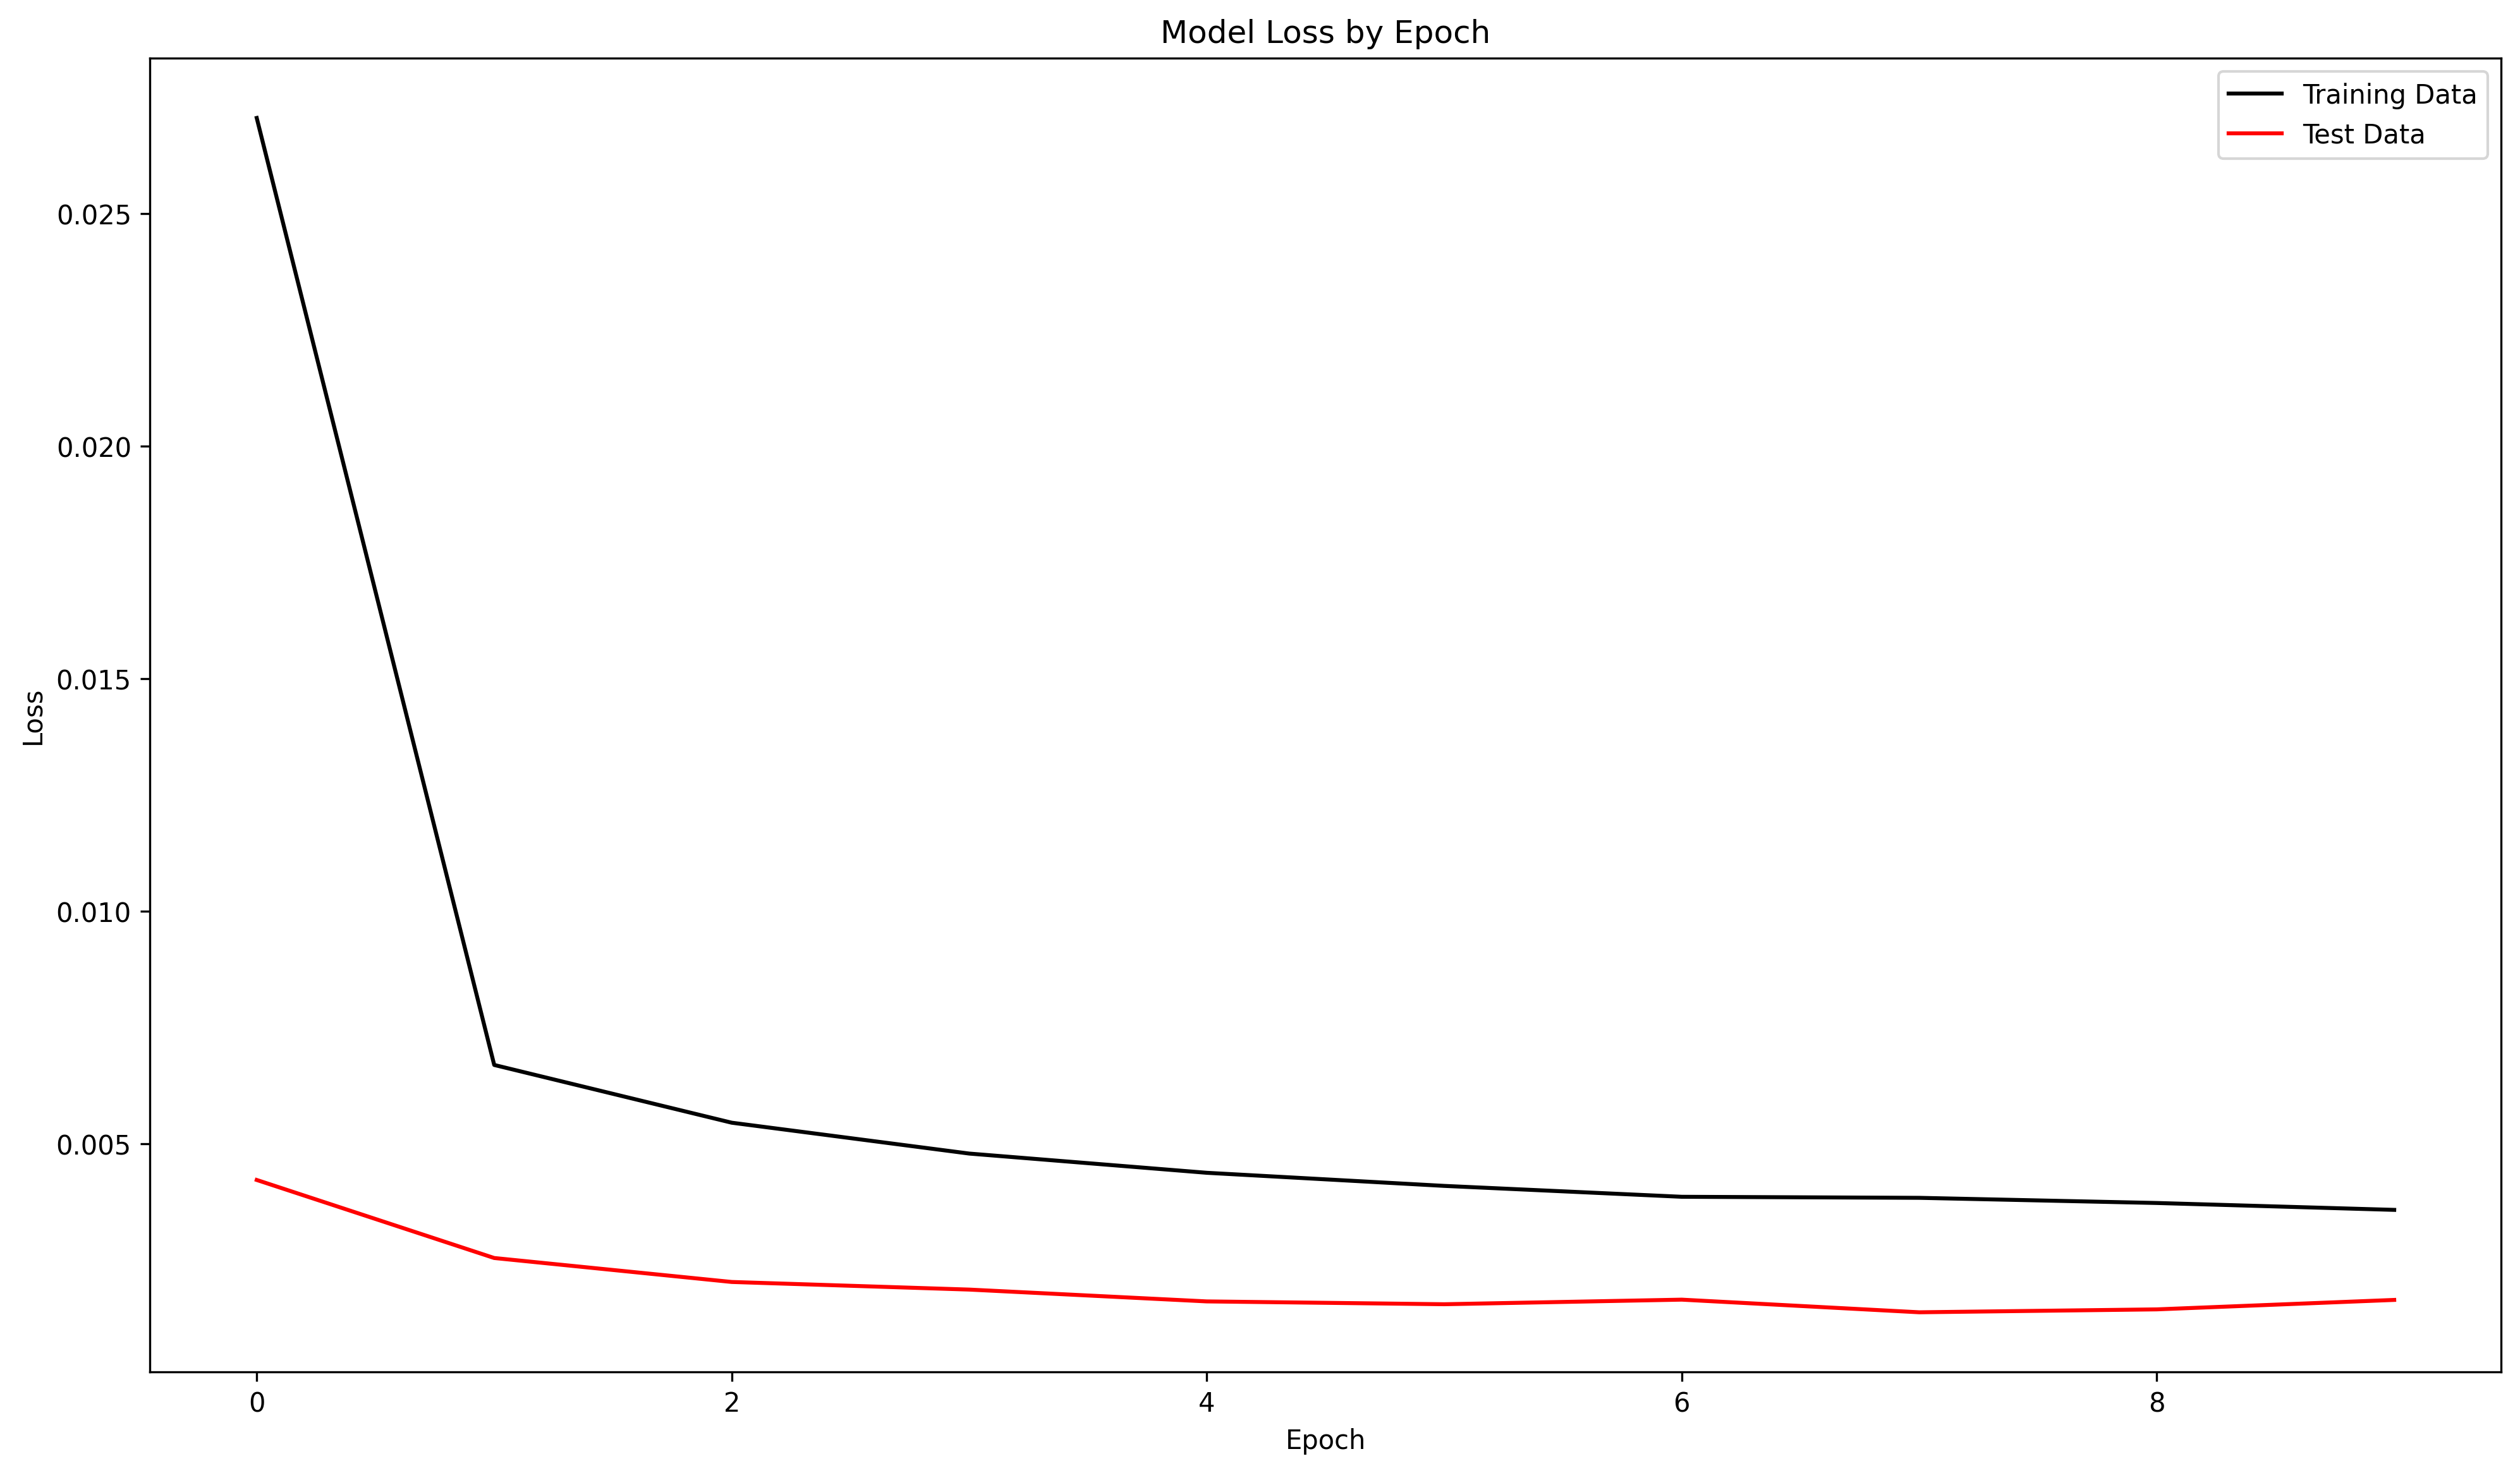

In [6]:
# Plot a loss chart
# Creates a figure for plotting with specified size and resolution.
fig, ax = plt.subplots(figsize=(16,9), dpi=300)

# Sets the title of the plot.
plt.title(label='Model Loss by Epoch', loc='center')

# Plots the training loss and test loss against the number of epochs.
ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')

# Sets labels for the x and y axes.
ax.set(xlabel='Epoch', ylabel='Loss')

# Adds a legend to the plot.
plt.legend()

# Displays the plot.
plt.show()

### From the plot we can see that with minimal loss our model is able to reconstruct the data.

### Seperate the encoders from the decoders and let's plot only the encoder part

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


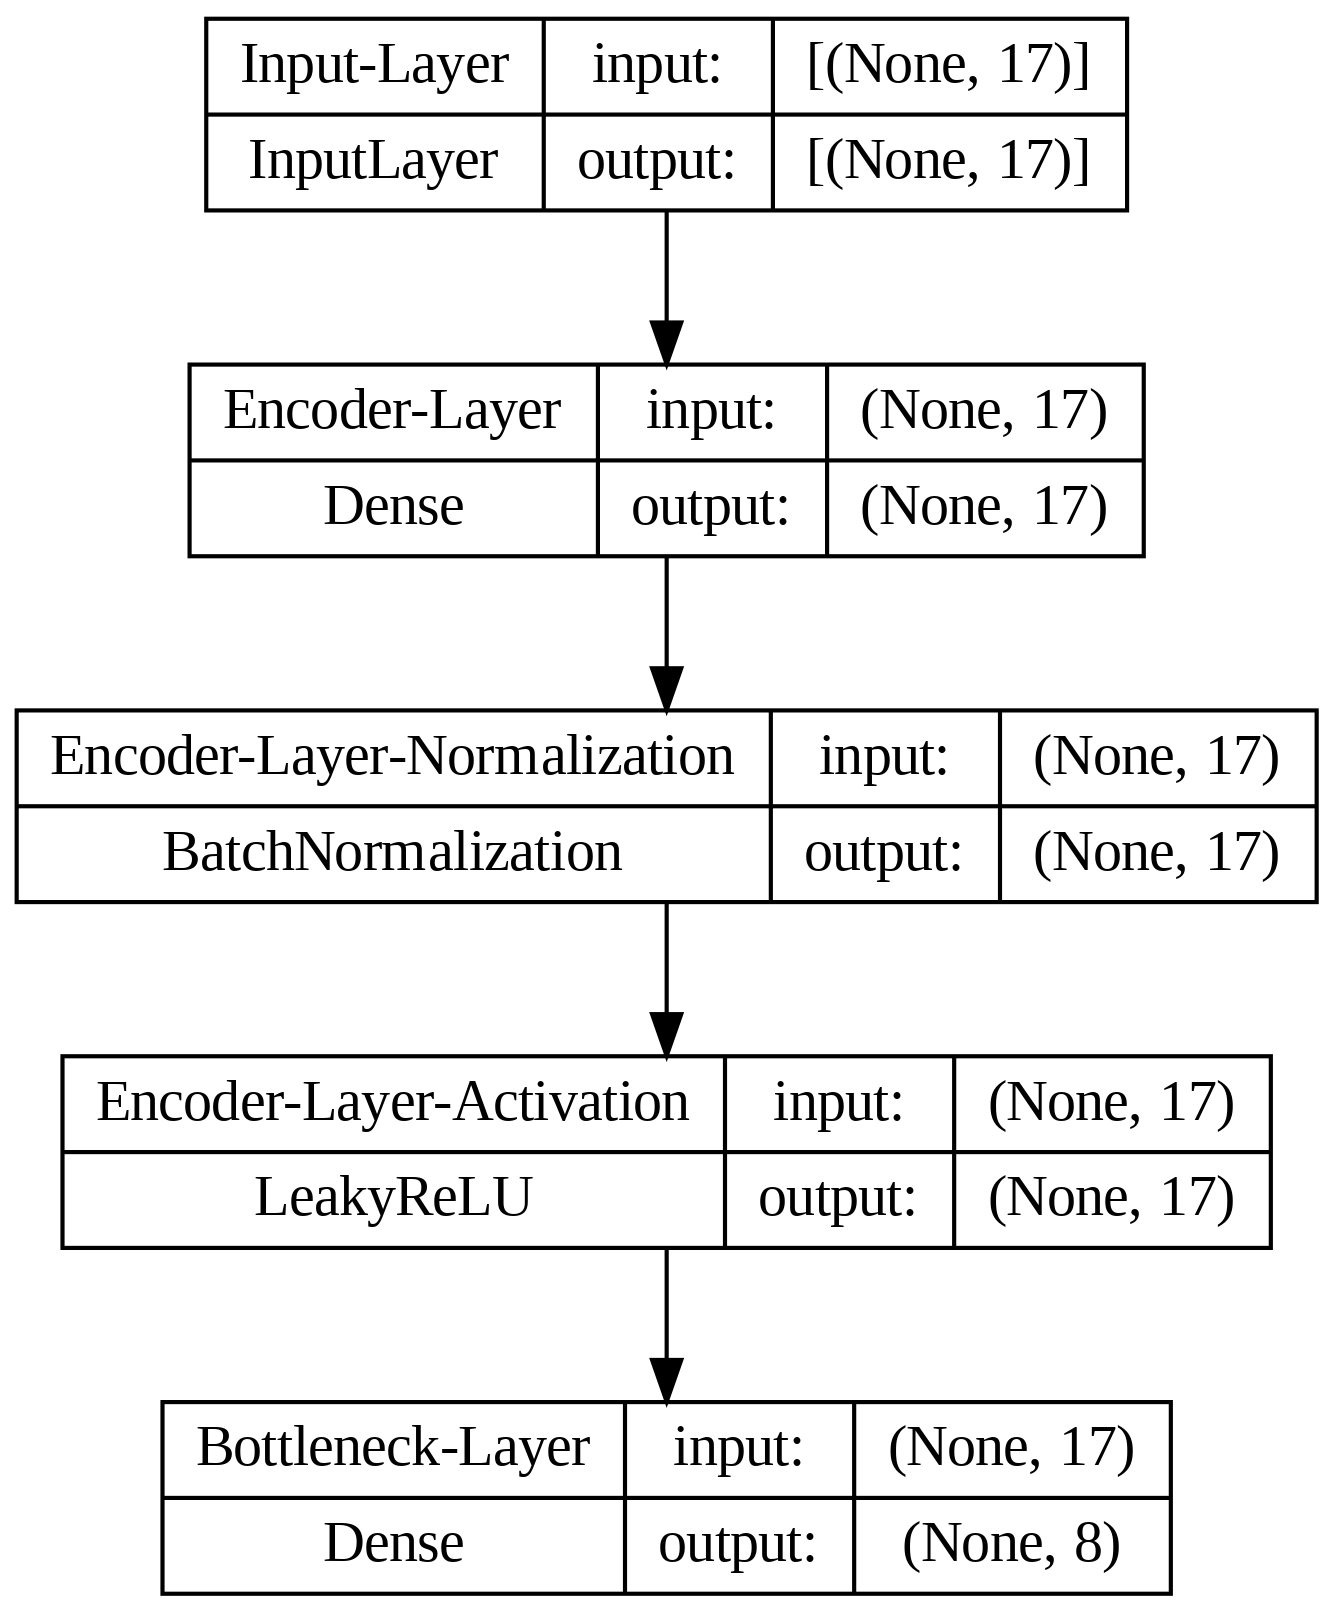

In [7]:
# Define an encoder model without the decoder
# Constructs an encoder model using the input layer and the bottleneck layer.
encoder = Model(inputs=visible, outputs=bottleneck)

# Compile encoder model
# Compiles the encoder model with the specified optimizer and loss function.
encoder.compile(optimizer='adam', loss='mse')

# Save the encoder model to file
# Saves the encoder model as an HDF5 file.
encoder.save(main_dir+'/content/encoder.h5')

# Plot the encoder model diagram
# Generates a visualization of the encoder model architecture and saves it as an image file.
plot_model(encoder, to_file=main_dir+'/content/Encoder_only.png', show_shapes=True, dpi=300)

### Let's seperate the decoders and plot only the decoders part

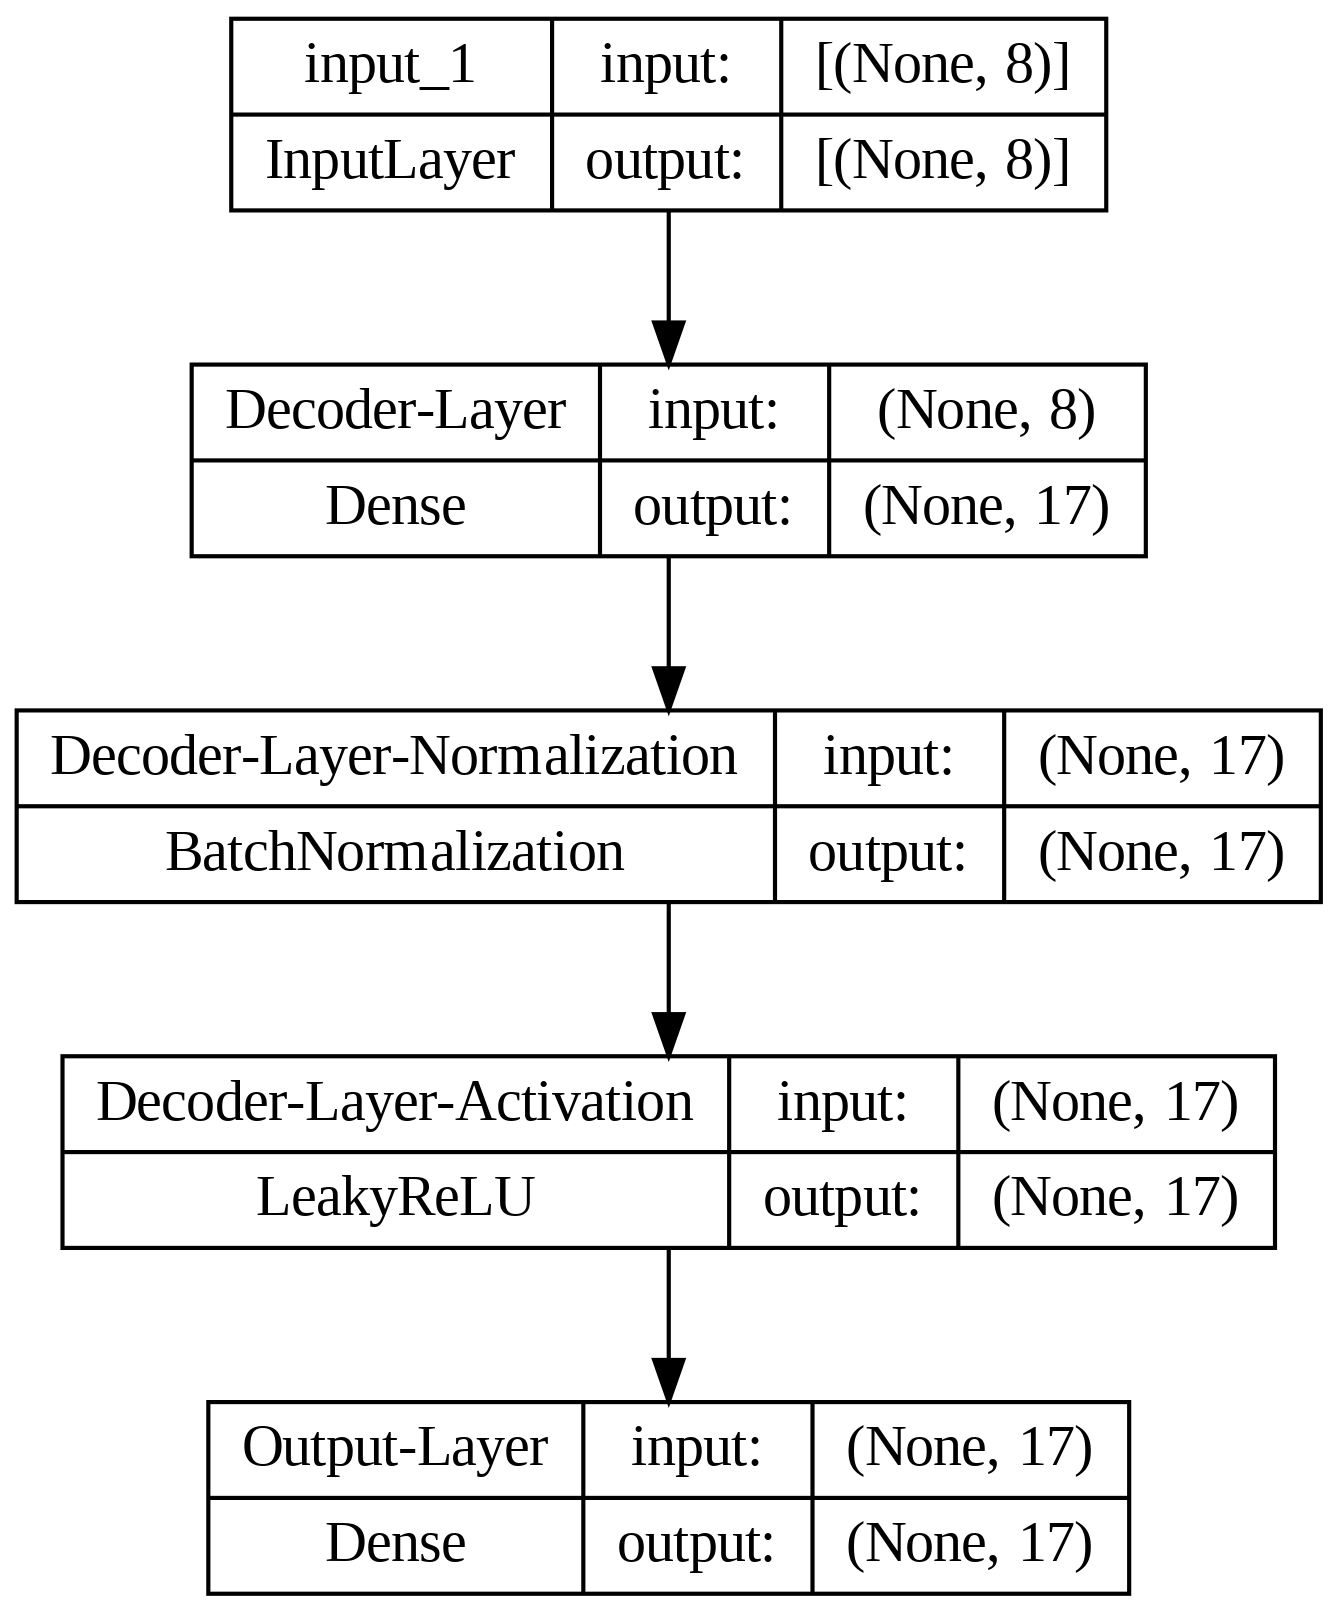

In [8]:
# Define a decoder model without the encoder
# Constructs a decoder model using the bottleneck layer as input and the output layer as output.
decoder = Model(inputs=bottleneck, outputs=output)

# Compile decoder model
# Compiles the decoder model with the specified optimizer and loss function.
decoder.compile(optimizer='adam', loss='mse')

# Save the decoder model to file
# Saves the decoder model as an HDF5 file.
decoder.save(main_dir+'/content/decoder.h5')

# Plot the decoder model diagram
# Generates a visualization of the decoder model architecture and saves it as an image file.
plot_model(decoder, to_file=main_dir+'/content/Decoder_only.png', show_shapes=True, dpi=300)

Whenever you need of these model by recalling them by using the below

In [9]:
# Load the encoder model from file
# Loads the previously saved encoder model from an HDF5 file.
encoder = load_model(main_dir+'/content/encoder.h5')

# Encode train and test data
# Applies the encoder model to transform the input data into its encoded representation.
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

353/353 [==============================] - 0s 1ms/step


## Step 4: Let's build two logistic regression models to predict tomorrow's rain probability.
Baseline without autoencoder

In [10]:
# Fit the logistic regression model
# Fits a logistic regression model to the training data.
model1 = LogisticRegression(solver='sag')
clf1 = model1.fit(X_train, y_train)

# Predict class labels on train and test data
# Predicts the class labels for the training and testing data using the trained logistic regression model.
pred_labels_tr1 = model1.predict(X_train)
pred_labels_te1 = model1.predict(X_test)

print('****************** Summary ******************')
# Print slope and intercept
# Outputs the intercept (Beta 0) and slope (Beta 1) of the logistic regression model.
print('Intercept (Beta 0): ', clf1.intercept_)
print('Slope (Beta 1): ', clf1.coef_)
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Test Data ***************')
# Calculate accuracy score on test data
# Computes the accuracy score of the logistic regression model on the test data.
score_te1 = model1.score(X_test, y_test)
print('Accuracy Score: ', score_te1)
# Look at classification report to evaluate the model
# Generates a classification report to evaluate the performance of the logistic regression model on the test data.
print(classification_report(y_test, pred_labels_te1))
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Training Data ***************')
# Calculate accuracy score on training data
# Computes the accuracy score of the logistic regression model on the training data.
score_tr1 = model1.score(X_train, y_train)
print('Accuracy Score: ', score_tr1)
# Look at classification report to evaluate the model
# Generates a classification report to evaluate the performance of the logistic regression model on the training data.
print(classification_report(y_train, pred_labels_tr1))
print('--------------------------------------------------------')
print("")

****************** Summary ******************
Intercept (Beta 0):  [-3.09276551]
Slope (Beta 1):  [[-1.64362023  0.41408612  1.72548111 -0.31677074 -2.19277823  6.40965917
  -0.95204028 -1.77088534  0.12810991  5.61072128  4.31754441 -8.19152203
  -0.18669401  1.02639121  0.77072623  1.12909546  0.45908531]]
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.859092520382843
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      8854
           1       0.72      0.56      0.63      2430

    accuracy                           0.86     11284
   macro avg       0.81      0.75      0.77     11284
weighted avg       0.85      0.86      0.85     11284

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.8526674937965261
              precision    recall  f1-score   support

     

Let's try with autoencoder

In [11]:
# Load the encoder model from file
# Loads the encoder model from the saved file.
encoder = load_model(main_dir+'/content/encoder.h5')

# Encode train and test data using the encoder model
# Encodes the training and testing data into a lower-dimensional representation using the encoder model.
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Fit the logistic regression model using encoded data
# Fits a logistic regression model to the encoded training data.
model2 = LogisticRegression(solver='sag')
clf2 = model2.fit(X_train_encoded, y_train)

# Predict class labels on train and test data
# Predicts the class labels for the training and testing data using the trained logistic regression model and the encoded data.
pred_labels_tr2 = model2.predict(X_train_encoded)
pred_labels_te2 = model2.predict(X_test_encoded)

print('****************** Summary ******************')
# Print slope and intercept
# Outputs the intercept (Beta 0) and slope (Beta 1) of the logistic regression model.
print('Intercept (Beta 0): ', clf2.intercept_)
print('Slope (Beta 1): ', clf2.coef_)
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Test Data ***************')
# Calculate accuracy score on test data
# Computes the accuracy score of the logistic regression model on the encoded test data.
score_te2 = model2.score(X_test_encoded, y_test)
print('Accuracy Score: ', score_te2)
# Look at classification report to evaluate the model
# Generates a classification report to evaluate the performance of the logistic regression model on the encoded test data.
print(classification_report(y_test, pred_labels_te2))
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Training Data ***************')
# Calculate accuracy score on training data
# Computes the accuracy score of the logistic regression model on the encoded training data.
score_tr2 = model2.score(X_train_encoded, y_train)
print('Accuracy Score: ', score_tr2)
# Look at classification report to evaluate the model
# Generates a classification report to evaluate the performance of the logistic regression model on the encoded training data.
print(classification_report(y_train, pred_labels_tr2))
print('--------------------------------------------------------')
print("")

353/353 [==============================] - 0s 1ms/step
****************** Summary ******************
Intercept (Beta 0):  [-2.5119517]
Slope (Beta 1):  [[-0.36896756 -0.6043194  -1.6583531   3.30652    -0.6782797   1.665628
   0.7230871  -0.25955892]]
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.8387982984757179
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      8854
           1       0.68      0.47      0.56      2430

    accuracy                           0.84     11284
   macro avg       0.77      0.71      0.73     11284
weighted avg       0.83      0.84      0.83     11284

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.8331265508684863
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     35139
        

<p align="center"><font size = ""><b> -- End of program -- </b><font></p>
<p align="center"><font size = "10"><b> Happy coding! ☺ </b><font></p>